# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

keywords are unexpanded, not using


In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,-0.580539,True,3.737223
1,-1.264492,True,1.009988
2,-0.192874,False,-0.747429
3,0.101457,True,4.045395
4,-0.318441,False,1.274264
...,...,...,...
995,0.542501,False,1.316512
996,-0.432295,True,3.467243
997,-1.155777,False,-2.957526
998,-0.336324,False,-1.651385


<AxesSubplot:xlabel='v0'>

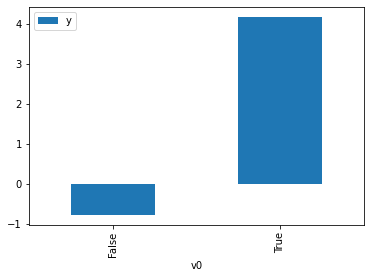

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot:xlabel='v0'>

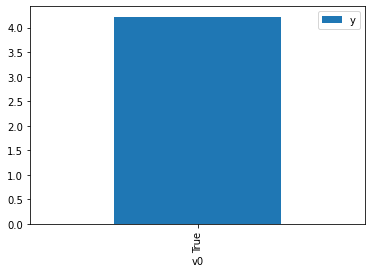

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,-0.781321,False,0.080065,0.651507,1.534902
1,-1.172325,False,-0.569889,0.713046,1.402435
2,0.345713,False,-0.172516,0.451522,2.214729
3,0.170839,False,0.864035,0.483192,2.069571
4,-1.510178,False,-1.910415,0.760622,1.314714
...,...,...,...,...,...
995,0.351293,False,-0.527595,0.450517,2.219671
996,1.122907,False,1.922839,0.318620,3.138530
997,-1.513897,False,-4.728532,0.761114,1.313863
998,1.577619,False,2.119202,0.251424,3.977346


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,-0.809650,True,4.140290,0.343827,2.908442
1,-1.626474,True,3.152577,0.224310,4.458123
2,-0.963730,True,6.317438,0.318990,3.134897
3,0.095476,True,6.153191,0.503103,1.987664
4,-2.089886,True,1.551312,0.171083,5.845115
...,...,...,...,...,...
995,-2.026945,True,0.979397,0.177677,5.628190
996,-1.095732,True,2.678643,0.298494,3.350156
997,0.762054,True,6.651279,0.621874,1.608043
998,-2.089886,True,1.551312,0.171083,5.845115


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.925
Model:                            OLS   Adj. R-squared (uncentered):              0.925
Method:                 Least Squares   F-statistic:                              6146.
Date:                Thu, 28 Jul 2022   Prob (F-statistic):                        0.00
Time:                        13:26:13   Log-Likelihood:                         -1460.6
No. Observations:                1000   AIC:                                      2925.
Df Residuals:                     998   BIC:                                      2935.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.7962      0.031     57.233      0.000       1.735       1.858
x2             5.0144      0.051     97.866      0.000       4.914       5.115
==============================================================================
Omnibus:                        2.058   Durbin-Watson:                   1.912
Prob(Omnibus):                  0.357   Jarque-Bera (JB):                1.919
Skew:                           0.096   Prob(JB):                        0.383
Kurtosis:                       3.097   Cond. No.                         1.64
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""